<a href="https://colab.research.google.com/github/siddharthkalyavit2025/Question-Classification-Model/blob/main/Question_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

print("Current directory:", os.listdir("."))
print("Inside MATH:", os.listdir("MATH"))
print("Train folders:", os.listdir("MATH/train"))
print("Test folders:", os.listdir("MATH/test"))


Saving dataset.zip to dataset (2).zip
Current directory: ['.config', 'dataset.zip', 'dataset (2).zip', 'MATH', 'dataset (1).zip', 'sample_data']
Inside MATH: ['test', 'train']
Train folders: ['counting_and_probability', 'prealgebra', 'number_theory', 'geometry', 'precalculus', 'algebra', 'intermediate_algebra']
Test folders: ['counting_and_probability', 'prealgebra', 'number_theory', 'geometry', 'precalculus', 'algebra', 'intermediate_algebra']


In [4]:
import os
import json

def load_data(base_path):
    X, y = [], []

    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if not os.path.isdir(label_path):
            continue

        for file in os.listdir(label_path):
            if file.endswith(".json"):
                with open(os.path.join(label_path, file), "r", encoding="utf-8") as f:
                    data = json.load(f)

                question = data.get("problem", "").strip()
                if question:
                    X.append(question)
                    y.append(label)

    return X, y


X_train, y_train = load_data("MATH/train")
X_test, y_test = load_data("MATH/test")

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))
print("Example:", X_train[0], "→", y_train[0])


Train samples: 7500
Test samples: 5000
Example: Two different numbers are randomly selected from the set $S = \{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11\}$. The probability that their sum is 12 would be greater if the number $n$ had first been removed from set $S$. What is the value of $n$? → counting_and_probability


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    lowercase=True,
    max_features=20000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_vec.shape)
print("TF-IDF test shape:", X_test_vec.shape)


TF-IDF train shape: (7500, 20000)
TF-IDF test shape: (5000, 20000)


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=3000)
model.fit(X_train_vec, y_train)

print("Model trained successfully ✅")


Model trained successfully ✅


In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7476

Classification Report:

                          precision    recall  f1-score   support

                 algebra       0.71      0.81      0.76      1187
counting_and_probability       0.76      0.69      0.72       474
                geometry       0.69      0.82      0.75       479
    intermediate_algebra       0.84      0.82      0.83       903
           number_theory       0.78      0.78      0.78       540
              prealgebra       0.59      0.53      0.56       871
             precalculus       0.98      0.80      0.88       546

                accuracy                           0.75      5000
               macro avg       0.76      0.75      0.75      5000
            weighted avg       0.75      0.75      0.75      5000



<Figure size 800x800 with 0 Axes>

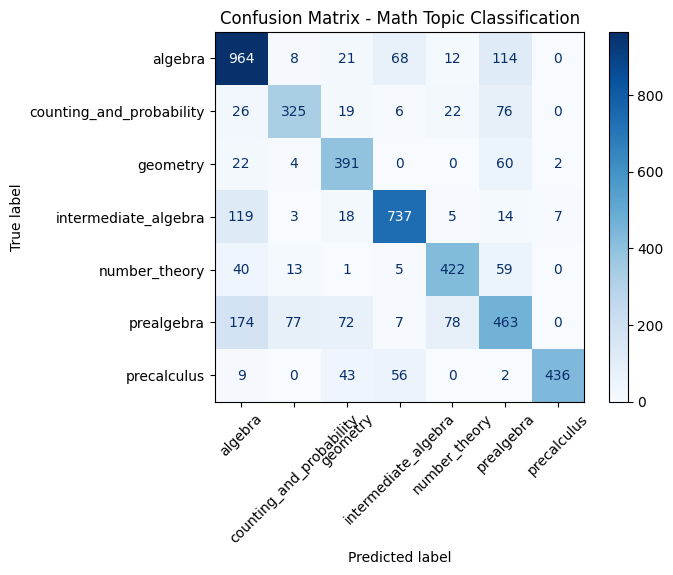

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_vec,
    y_test,
    xticks_rotation=45,
    cmap="Blues"
)
plt.title("Confusion Matrix - Math Topic Classification")
plt.show()


In [19]:
def predict_topic(question):
    return model.predict(vectorizer.transform([question]))[0]

question = "Find the minimum value of z = x^2 + 2y^2 + 6x - 4y + 22"
print("Predicted Topic:", predict_topic(question))


Predicted Topic: intermediate_algebra


LLM


In [10]:
!pip install -q transformers accelerate bitsandbytes sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.5 MB/s eta 0:00:00


In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

print("LLM loaded ✅")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LLM loaded ✅


In [12]:
def build_prompt(question):
    return f"""
You are a high school mathematics teacher.

Solve the following problem step by step.
Use simple language.
Explain each step clearly.
Avoid advanced jargon.
Clearly state the final answer.

Question:
{question}

Answer:
"""


In [21]:
def generate_solution(question, max_tokens=300):
    prompt = build_prompt(question)

    inputs = tokenizer(prompt, return_tensors="pt").to(llm.device)

    outputs = llm.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [14]:
question = "Find the minimum value of z = x^2 + 2y^2 + 6x - 4y + 22"

solution = generate_solution(question)

print(solution)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are a high school mathematics teacher.

Solve the following problem step by step.
Use simple language.
Explain each step clearly.
Avoid advanced jargon.
Clearly state the final answer.

Question:
Find the minimum value of z = x^2 + 2y^2 + 6x - 4y + 22

Answer:
To find the minimum value of the expression z = x^2 + 2y^2 + 6x - 4y + 22, we need to find the vertex of the parabola represented by this equation. Since there is no constant term a in the quadratic part x^2 + 2y^2, this is a special kind of quadratic function called a circle.

To find the center of the circle, we can complete the square for the x and y terms separately:

1. For x: x = (6 - y) / 2, then x^2 = ((6 - y) / 2) ^ 2 = (3 - y) ^ 2. Completing the square for x^2, we get x^2 = (3 - y) ^ 2 + 9/4 - 9/4.

2. For y: y = -2x/2 - 1, then y^2 = (-2x/2 - 1) ^ 2 = (-x - 1/2) ^ 2. Completing the square for y^2, we get y^2 = (-x - 1/2) ^ 2 + 1/4.

3. Adding the constant terms for x and y, we get the center of the circle: (3/2, 

In [22]:
question = "Find the derivative of x^3 + 5x"

topic = predict_topic(question)
solution = generate_solution(question)

print("Predicted Topic:", topic)
print("\nStudent-Friendly Solution:\n")
print(solution)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Predicted Topic: intermediate_algebra

Student-Friendly Solution:


You are a high school mathematics teacher.

Solve the following problem step by step.
Use simple language.
Explain each step clearly.
Avoid advanced jargon.
Clearly state the final answer.

Question:
Find the derivative of x^3 + 5x

Answer:
To find the derivative of a function, we need to use the power rule. The power rule states that if we have a term x^n in a function, then the derivative of that term is n * x^(n-1).

Step 1: Identify the terms in the function.
The function given is x^3 + 5x. It has two terms: x^3 and 5x.

Step 2: Apply the power rule to each term.
For the first term x^3:
The exponent is 3. According to the power rule, the derivative of x^3 is 3 * x^(3-1) or 3x^2.

For the second term 5x:
The coefficient is 5. The exponent is 1 (x is considered as having an implicit exponent of 1 when it's not explicitly stated). According to the power rule, the derivative of 5x is 5 * x^(1-1) or 5x^0 which simplifie